Ideas: Introducimos la data en un Pandas. Iteramos sobre las columnas y analizamos los valores posibles para cada columna, incluyendo la clase de cada caso. Podemos crear luego un objeto que sea conjunto o algo asi, y ese objeto le damos el metodo "entropia". Aparte, creamos una funcion que reciba uno de estos conjuntos y tome los atributos que analizamos de la tabla. La funcion itera sobre la lista de atributos y nos devuelve el atributo con mayor ganancia
Ahi miramos si tenemos suficiente ganancia, sit enemos, creamos un nodo y separamos cada caso dependiendo del valor del atributo en subconjuntos. Guardamos los subconjuntos en una lista en el nodo y llamamos al algoritmo con los elementos de la lista.

In [ ]:
import pandas as pd
import math
import streamlit as st
import graphviz as graphviz

In [ ]:
df = pd.read_csv('mushrooms.csv').head(10)
df['class'].value_counts().items()

In [ ]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
 list(df['class'].value_counts().values)

[4208, 3916]

In [ ]:
df['class'].mode().item()

'e'

In [ ]:
classValues = list(df['class'].value_counts().index) # Valores posibles de la columna clase
classValues

['e', 'p']

In [ ]:
class SetCases:
    def __init__(self,cases,case_count,class_column_name):
        self.cases = cases
        self.class_column_name = class_column_name
        self.case_count = case_count
        self.columns = list(cases.columns)
        #self.attributes = self.columns
        self.attributes = [item for item in self.columns if item != self.class_column_name] # This is 'A' in the theory
        #self.attributes.remove(self.class_column_name)  
    def cases_count(self):
        self.case_count = self.cases.shape[0]
        return self.case_count
        
    def get_attributes(self) -> list:
        return self.attributes
    
    def entropy(self) -> float:  # Entropy Formula function
        entropy = 0
        counts = self.cases[self.class_column_name].value_counts()
        for item in classValues:
            prob = self.cases[self.cases[self.class_column_name]==item][self.class_column_name].count()/self.case_count
            entropy -= (prob)*(math.log2(prob))
        return round(entropy,3)

    def entropy_attribute(self) -> float: # Entropia de cada tributo de 'A'
        entropy_result = {}
        for attribute in self.attributes:  # Bucle sobre cada atributo de la lista
            result = 0
            attr_indexes = list(self.cases[attribute].value_counts().index)
            attr_counts = list(self.cases[attribute].value_counts().values)
            i=0
            for value in attr_indexes: # Bucle sobre los valores posibles de cada atributo
                attr_entropy = 0
                attr_count = attr_counts[i]

                for c_value in classValues: # Bucle sobre cada caso de un valor posible de un atributo
                    class_count = len(self.cases[(self.cases[attribute]==value)&(self.cases[self.class_column_name]==c_value)])
                    if class_count != 0:
                        attr_entropy -= (class_count/attr_count) * (math.log2((class_count/attr_count)))
                    else:
                        attr_entropy -= 0 #ESTO SE TENDRIA QUE SACAR DE ACA, CUANDO ESTE EL CODIGO COMPLETO ESTO IRIA AL PRINCIPIO
                i+=1

                result += (attr_count/self.case_count) * attr_entropy # Resultado de entropia de un atributo posible
            entropy_result[attribute] = result
        return entropy_result

    def gain(self) -> list: # return [Att, Value]
        entropy = self.entropy()
        entropy_atts = self.entropy_attribute()
        max_gain = 0
        curr_gain = 0
        result = [0,0]
        for key,value in entropy_atts.items():
            curr_gain = float(entropy) - value 
            if curr_gain > max_gain:
                max_gain = curr_gain
                result[0] = key
                result[1] = curr_gain
        return result

    def gain2(self) -> list: # return list of [Att, Value], something like: [[Att1, Value] [Att2, Value]] 
        entropy = self.entropy()
        entropy_atts = self.entropy_attribute()
        curr_gain = 0
        max_gain = 0
        result = []
        for key,value in entropy_atts.items():
            curr_gain = float(entropy) - value
            if curr_gain > max_gain:
                result.insert(0, [key, curr_gain])
                max_gain=curr_gain
            else:
                result.append([key, curr_gain])      
        return result
    
    def gain_ratio(self) -> list:
        entropy = self.entropy()
        gain = self.gain2()
        split_info = 0
        max_gain_rate = 0
        result=[0,0]
        for att_name, gain_per_att in gain: # gain is [Att, Value]
            # We generate a list of all the quantities of occurences of each attribute
            attr_counts = list(self.cases[att_name].value_counts().values) # 
            split_info = 0
            for attr_count in attr_counts:
                split_info -= (attr_count/self.case_count) * (math.log2((attr_count/self.case_count)))
                print("Split Info", split_info, gain_per_att)
            curr_gain_rate = gain_per_att / split_info
            if curr_gain_rate > max_gain_rate: 
                max_gain_rate = curr_gain_rate
                result[0] = att_name
                result[1] = curr_gain_rate
        return result

    def is_pure(self) -> bool:
        classes = self.cases[self.class_column_name].unique()
        if len(classes) == 1:
            return True
        return False
    
    def most_frequent_class(self) -> str:
        return self.cases[self.class_column_name].mode().item()
    
    def separate_data(self, attr) -> list: # Esto retorna un arreglo con dataframes
        attr_values = list(self.cases[attr].unique())
        frames = []
        for val in attr_values:
            frames.append([val, self.cases[self.cases[attr]==val] ])
        return frames

In [ ]:
name_counter = 1

In [ ]:
class Node:
    def __init__(self, data: SetCases, id_node: int , val_attr = None):
        self.data = data
        self.children = []
        self.curr_class = ''
        self.chosen_att = ''
        self.id_node = id_node
        self.val_attr = val_attr
        self.gain = 0
        global name_counter

    def addChildren(self, node):
        self.children.append(node)
        
    def printTree(self, depth: int, graph, previous_node, name_previous_node: int):
        print('###############################################')
        print(f"Depth {depth}")
        print(self.curr_class)
        global name_counter
        if self.chosen_att != '':
            print(f'Created node with name {self.id_node} and label {self.chosen_att}')
            graph.node(name = str(self.id_node),label = f'{self.chosen_att} \n Gain: {self.gain}')
        else:
            print(f'Created node with name {self.id_node} and label {self.curr_class}')
            print(self.data.cases[self.data.class_column_name].value_counts())
            graph.node(name = str(self.id_node), label= f'{self.curr_class} \n Gain: {self.gain} \n {self.data.cases[self.data.class_column_name].value_counts().values}',color='green')
        if depth != 0:
            print(f'Created edge between {name_previous_node} and {self.id_node}')
            graph.edge(str(name_previous_node), str(self.id_node))
        #name_counter+=1
        name_previous_node+=1
        for item in self.children:
            item.printTree(depth+1, graph, self, self.id_node)
        

In [ ]:
"""
print(root_node.data.class_column_name)
print(root_node.data.cases)
print(root_node.data.cases[root_node.data.class_column_name])
print(root_node.children[0].data.cases)
print(root_node.children[0].data.cases[root_node.children[0].data.class_column_name])
"""

'\nprint(root_node.data.class_column_name)\nprint(root_node.data.cases)\nprint(root_node.data.cases[root_node.data.class_column_name])\nprint(root_node.children[0].data.cases)\nprint(root_node.children[0].data.cases[root_node.children[0].data.class_column_name])\n'

In [ ]:
def decisionTree(D : SetCases, A : list, T : Node, guide_int : int):
    global name_counter
    if D.is_pure():
        class_name = D.most_frequent_class()
        T.curr_class = class_name
    elif not A:
        class_name = D.most_frequent_class()
        T.curr_class = class_name
    else:
        print('Depth ' + str(guide_int))
        #gain = D.gain()
        gain = D.gain_ratio()
        #gain = D.gain2()[0]
        print('Attribute chosen '+ gain[0])
        print("ACA ESTA LA GANANCIA",gain[1])
        if gain[1] < threshold:
            class_name = D.most_frequent_class()
            T.curr_class = class_name
        else:
            T.chosen_att = gain[0]
            A1 = [item for item in A if item != gain[0]]
            subsets = D.separate_data(gain[0])
            for subset in subsets:
                elem = SetCases(subset[1], len(subset[1]), D.class_column_name)
                print(f'Name_counter {name_counter} Size {subset[1].shape}')
                T.gain = round(gain[1],2)
                new_node = Node(elem, name_counter, subset[0])
                name_counter+=1
                T.addChildren(new_node)
                decisionTree(elem, A1, new_node, guide_int+1)

In [ ]:
graph = graphviz.Digraph()

In [ ]:
threshold = 0.05
set_init = SetCases(df,len(df),'class')
root_node = Node(set_init, 0)
decisionTree(set_init, set_init.get_attributes(),root_node,0)


Split Info 1.4952329751257345 0.019239115693178155
Split Info 1.9390591942632778 0.019239115693178155
Split Info 1.9658994103044949 0.019239115693178155
Split Info 0.42503316777584116 0.007536105770635126
Split Info 0.9556222693531469 0.007536105770635126
Split Info 0.0 0.00026853175033625387
Split Info 0.0 0.00026853175033625387
Split Info 0.4693822960739032 0.027271799613788728
Split Info 0.9901226308935798 0.027271799613788728
Split Info 0.48413786985908475 0.062159848532709394
Split Info 0.9020844734913567 0.062159848532709394
Split Info 1.3200310771236285 0.062159848532709394
Split Info 1.7379776807559004 0.062159848532709394
Split Info 0.0 0.00026853175033625387
Split Info 0.2217446572009569 0.0006009014198802842
Split Info 0.6550239908788728 0.0006009014198802842
Split Info 0.4045002278702446 0.05971593881623438
Split Info 0.9208873484581315 0.05971593881623438
Split Info 1.1032960772882774 0.05971593881623438
Split Info 1.2400957276959372 0.05971593881623438
Split Info 0.404500

KeyboardInterrupt: 

In [ ]:
root_node.printTree(0, graph, root_node,name_counter)

###############################################
Depth 0

Created node with name 0 and label gill-size
###############################################
Depth 1
['p']
Created node with name 1 and label ['p']
p    3
Name: class, dtype: int64
Created edge between 0 and 1
###############################################
Depth 1
['e']
Created node with name 2 and label ['e']
e    7
Name: class, dtype: int64
Created edge between 0 and 2


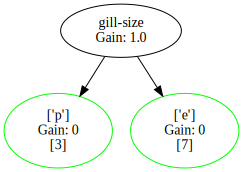

In [ ]:

graph 

## Predicciones

In [ ]:
def predict_case(case, node: Node):
    while node.children:
        node_att = node.chosen_att
        case_att = case[node_att]
        for child in node.children:
            if case_att == child.val_attr:
                node = child
                break
    return node.curr_class
        


In [ ]:
def predict_cases(cases,node:Node):
    predictions = []
    for item,value in cases.iterrows():
        aux = node
        predictions.append(predict_case(value, aux))
    return predictions

In [ ]:
pos = 0
df.loc[pos:pos]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u


In [ ]:
test = df.loc[pos:pos]

In [ ]:
#predict_case(test,root_node)

In [ ]:
df['test_result'] = predict_cases(df,root_node)

In [ ]:
df[['class','test_result']]

,class,test_result
0,p,[p]
1,e,[e]
2,e,[e]
3,p,[p]
4,e,[e]
5,e,[e]
6,e,[e]
7,e,[e]
8,p,[p]
9,e,[e]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a66d969-af84-4258-a4a2-724e61aa71b5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>